In [1]:
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.utils import resample
from scipy.stats import chi2_contingency
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('SADIPEMCONSULTAPUBLICAGERALBATCH11112024.csv', encoding='latin1', delimiter=';')

In [2]:
data.columns = data.columns.str.strip()
data = data.applymap(lambda x: x.strip() if isinstance(x, str) else x)

data["Valor"] = data["Valor"].str.replace('.', '', regex=False).str.replace(',', '.', regex=False)
data["Valor"] = pd.to_numeric(data["Valor"], errors='coerce')

data["Data"] = pd.to_datetime(data["Data"], format='%d/%m/%Y', errors='coerce')

data = data.dropna()

data["Ano"] = data["Data"].dt.year
data["Mes"] = data["Data"].dt.month
data["Dia"] = data["Data"].dt.day
data = data.drop(columns=["Data"])

data = data.drop_duplicates()

print("Dados originais:")
print(data.head())
print(data.info())
print(data.describe())

C:\Users\lucas\AppData\Local\Temp\ipykernel_24940\1173201944.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data = data.applymap(lambda x: x.strip() if isinstance(x, str) else x)


Dados originais:
           Interessado  UF Tipo de interessado             Tipo de operação  \
0  Abadia dos Dourados  MG           Município  Operação Contratual Interna   
1  Abadia dos Dourados  MG           Município  Operação Contratual Interna   
2  Abadia dos Dourados  MG           Município  Operação Contratual Interna   
3  Abadia dos Dourados  MG           Município  Operação Contratual Interna   
4  Abadia dos Dourados  MG           Município  Operação Contratual Interna   

                                       Finalidade  \
0                                    Provias 2009   
1                               Caminho da Escola   
2                                    Provias 2009   
3                        Caminho da Escola 2009 A   
4  Aquisição de máquinas, equipamentos e veículos   

                    Tipo de credor  \
0  Instituição Financeira Nacional   
1  Instituição Financeira Nacional   
2  Instituição Financeira Nacional   
3  Instituição Financeira Nacional   

In [3]:

Q1 = data["Valor"].quantile(0.25)
Q3 = data["Valor"].quantile(0.75)
IQR = Q3 - Q1


lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR


data_without_outliers = data[(data["Valor"] >= lower_bound) & (data["Valor"] <= upper_bound)]


In [4]:
status_mapping_fluxograma = {
    "Deferido": "Aprovado",
    "Deferido (PVL-IF)": "Aprovado",
    "Arquivado": "Não Aprovado",
    "Devolvido": "Não Aprovado",
    "Arquivado por decurso de prazo": "Não Aprovado",
    "Encaminhado à PGFN com manifestação técnica favorável": "Aprovado",
    "Regularizado": "Aprovado",
    "Arquivado a pedido": "Não Aprovado",
    "Em retificação pelo interessado": "Em Análise",
    "Indeferido": "Não Aprovado",
    "Em retificação pelo credor": "Em Análise",
    "Arquivado por decurso de prazo (PVL-IF)": "Não Aprovado",
    "Arquivado a pedido (PVL-IF)": "Não Aprovado",
    "Em retificação pelo interessado (PVL-IF)": "Em Análise",
    "Encaminhado à PGFN (decisão judicial)": "Em Análise",
    "Em retificação pelo credor (PVL-IF)": "Em Análise",
    "Cancelado": "Não Aprovado",
    "Pendente de regularização": "Em Análise",
    "Em análise": "Em Análise",
    "Arquivado pela STN": "Não Aprovado",
    "Deferido (decisão judicial)": "Aprovado",
    "Assinado pelo interessado (retificação)": "Em Análise",
    "Em análise (PVL-IF)": "Em Análise",
    "Regular por decisão judicial": "Aprovado",
    "Enviado à instituição financeira (PVL-IF)": "Em Análise",
    "Indeferido (PVL-IF)": "Não Aprovado",
    "PVL cancelado": "Não Aprovado"
}

data_without_outliers["Status"] = data_without_outliers["Status"].map(status_mapping_fluxograma)

em_analise_fluxograma = data_without_outliers[data_without_outliers["Status"] == "Em Análise"]

status_counts_fluxograma = data_without_outliers["Status"].value_counts()
print("\nContagem por classificação (sem outliers):")
print(status_counts_fluxograma)



Contagem por classificação (sem outliers):
Status
Aprovado        17062
Não Aprovado     4707
Em Análise        179
Name: count, dtype: int64


C:\Users\lucas\AppData\Local\Temp\ipykernel_24940\1971016842.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_without_outliers["Status"] = data_without_outliers["Status"].map(status_mapping_fluxograma)



=== Análise de Viés por Analisador ===

1. Distribuição de Processos por Analisador:
Analisado por
STN                       16090
Instituição Financeira     5858
Name: count, dtype: int64

2. Tabela Cruzada (Status vs Analisador):
Analisado por  Instituição Financeira    STN
Status                                      
Aprovado                         5670  11392
Em Análise                         88     91
Não Aprovado                      100   4607

3. Proporções de Status por Analisador:
Analisado por  Instituição Financeira       STN
Status                                         
Aprovado                     0.967907  0.708017
Em Análise                   0.015022  0.005656
Não Aprovado                 0.017071  0.286327

4. Resultados do Teste Qui-Quadrado:
Estatística Chi2: 1871.0739
p-valor: 0.0000
Graus de Liberdade: 2


<Figure size 1500x800 with 0 Axes>

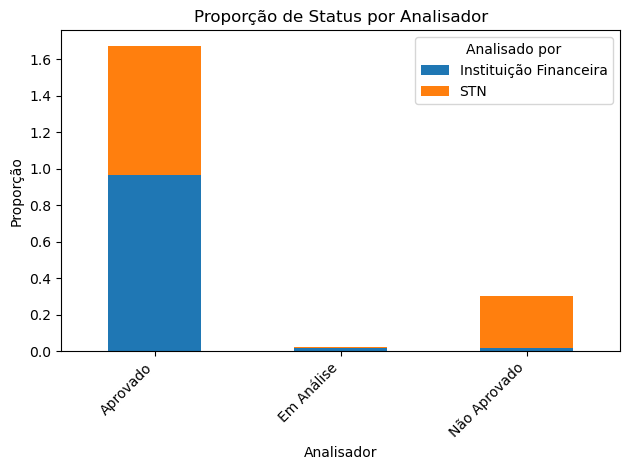


Conclusão da Análise de Viés:

    ATENÇÃO: Foi detectada uma associação estatisticamente significativa 
    entre o analisador e o status dos processos (p-valor < 0.05).
    Isso pode indicar potencial viés no processo de análise.
    


In [5]:
print("\n=== Análise de Viés por Analisador ===")

# Distribuição de Processos por Analisador
print("\n1. Distribuição de Processos por Analisador:")
dist_analisadores = data_without_outliers['Analisado por'].value_counts()
print(dist_analisadores)

# Tabela Cruzada (Status vs Analisador)
print("\n2. Tabela Cruzada (Status vs Analisador):")
contagem_cruzada = pd.crosstab(data_without_outliers['Status'], data_without_outliers['Analisado por'])
print(contagem_cruzada)

# Proporções de Status por Analisador
print("\n3. Proporções de Status por Analisador:")
proporcoes = contagem_cruzada.apply(lambda x: x / x.sum(), axis=0)
print(proporcoes)

# Teste Qui-Quadrado
chi2, p_valor, dof, expected = chi2_contingency(contagem_cruzada)
print("\n4. Resultados do Teste Qui-Quadrado:")
print(f"Estatística Chi2: {chi2:.4f}")
print(f"p-valor: {p_valor:.4f}")
print(f"Graus de Liberdade: {dof}")

# Tempo Médio de Análise por Analisador (em dias)
if 'Data' in data_without_outliers.columns:
    data_without_outliers['Data'] = pd.to_datetime(data_without_outliers['Data'])
    tempo_medio = data_without_outliers.groupby('Analisado por')['Data'].agg(['min', 'max'])
    tempo_medio['tempo_medio_dias'] = (tempo_medio['max'] - tempo_medio['min']).dt.days
    print("\n5. Tempo Médio de Análise por Analisador (em dias):")
    print(tempo_medio['tempo_medio_dias'])

# Gráfico de Proporção de Status por Analisador
plt.figure(figsize=(15, 8))
proporcoes.plot(kind='bar', stacked=True)
plt.title('Proporção de Status por Analisador')
plt.xlabel('Analisador')
plt.ylabel('Proporção')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Conclusão da Análise de Viés
print("\nConclusão da Análise de Viés:")
if p_valor < 0.05:
    print("""
    ATENÇÃO: Foi detectada uma associação estatisticamente significativa 
    entre o analisador e o status dos processos (p-valor < 0.05).
    Isso pode indicar potencial viés no processo de análise.
    """)
else:
    print("""
    Não foram encontradas evidências estatísticas de viés sistemático 
    na distribuição de status entre os diferentes analisadores.
    """)

In [6]:
data_without_outliers = data_without_outliers.drop(columns=['Analisado por'])


In [7]:
em_analise_dados = data_without_outliers[data_without_outliers["Status"] == "Em Análise"]
dados_sem_analise = data_without_outliers[data_without_outliers["Status"] != "Em Análise"]
em_analise_dados.to_csv('dados_em_analise.csv', index=False)
dados_sem_analise_encoded = dados_sem_analise.copy()
"Dados 'Em Análise' foram separados e salvos."


"Dados 'Em Análise' foram separados e salvos."

In [8]:

y = dados_sem_analise_encoded["Status"]


data_combined = dados_sem_analise_encoded.copy()
data_combined["Status"] = y


classes = {status: data_combined[data_combined["Status"] == status] for status in y.unique()}


max_size = max(len(classes[status]) for status in classes)
oversampled_classes = [
    resample(data, replace=True, n_samples=max_size, random_state=42) if len(data) < max_size else data
    for data in classes.values()
]


min_size = min(len(classes[status]) for status in classes)
undersampled_classes = [
    resample(data, replace=False, n_samples=min_size, random_state=42) if len(data) > min_size else data
    for data in classes.values()
]


oversampled_data = pd.concat(oversampled_classes).reset_index(drop=True)
undersampled_data = pd.concat(undersampled_classes).reset_index(drop=True)


oversampled_distribution = oversampled_data["Status"].value_counts()
undersampled_distribution = undersampled_data["Status"].value_counts()

if oversampled_data.isna().any().any():  
    print("NaN encontrado no oversampled_data! Removendo...")
    oversampled_data = oversampled_data.dropna()  


if undersampled_data.isna().any().any():  
    print("NaN encontrado no undersampled_data! Removendo...")
    undersampled_data = undersampled_data.dropna() 

{
    "Oversampled Distribution": oversampled_distribution,
    "Undersampled Distribution": undersampled_distribution
}


{'Oversampled Distribution': Status
 Não Aprovado    17062
 Aprovado        17062
 Name: count, dtype: int64,
 'Undersampled Distribution': Status
 Não Aprovado    4707
 Aprovado        4707
 Name: count, dtype: int64}

In [9]:

if 'oversampled_data' in locals():
    X = oversampled_data.drop(columns=["Status"])  
    y = oversampled_data["Status"].astype(str)  
else:
    raise ValueError("Os dados balanceados (oversampled_data) não estão definidos. Por favor, forneça os dados.")


numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns


for col in categorical_cols:
    X[col] = X[col].astype('category').cat.codes  


X_processed = pd.concat([X[numerical_cols], X[categorical_cols]], axis=1)


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_processed)


models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Bagging": BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=50),
    "Decision Tree": DecisionTreeClassifier(),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Naive Bayes": GaussianNB()
}


kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)


results = {model_name: {"accuracy": [], "precision": [], "recall": [], "f1": []} for model_name in models}


for model_name, model in models.items():
    print(f"Treinando e avaliando: {model_name}")

    for fold, (train_index, test_index) in enumerate(kf.split(X_scaled, y), start=1):
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        
        model.fit(X_train, y_train)

        
        y_pred = model.predict(X_test)

        
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

        
        results[model_name]["accuracy"].append(accuracy)
        results[model_name]["precision"].append(precision)
        results[model_name]["recall"].append(recall)
        results[model_name]["f1"].append(f1)


summary = {
    model_name: {
        "Accuracy (Mean)": np.mean(metrics["accuracy"]),
        "Precision (Mean)": np.mean(metrics["precision"]),
        "Recall (Mean)": np.mean(metrics["recall"]),
        "F1-Score (Mean)": np.mean(metrics["f1"])
    }
    for model_name, metrics in results.items()
}


summary_df = pd.DataFrame(summary).T
summary_df.sort_values(by="F1-Score (Mean)", ascending=False, inplace=True)


print(summary_df)


Treinando e avaliando: Logistic Regression
Treinando e avaliando: Random Forest
Treinando e avaliando: Bagging
Treinando e avaliando: Decision Tree
Treinando e avaliando: KNN
Treinando e avaliando: Naive Bayes
                     Accuracy (Mean)  Precision (Mean)  Recall (Mean)  \
Random Forest               0.958475          0.959895       0.958475   
Bagging                     0.952907          0.954883       0.952907   
Decision Tree               0.936994          0.941067       0.936994   
KNN                         0.855849          0.862783       0.855849   
Naive Bayes                 0.748183          0.748534       0.748183   
Logistic Regression         0.734410          0.736030       0.734410   

                     F1-Score (Mean)  
Random Forest               0.958443  
Bagging                     0.952856  
Decision Tree               0.936847  
KNN                         0.855158  
Naive Bayes                 0.748099  
Logistic Regression         0.733962  


In [10]:

if 'undersampled_data' in locals():
    X = undersampled_data.drop(columns=["Status"])  
    y = undersampled_data["Status"].astype(str) 
else:
    raise ValueError("Os dados balanceados (undersampled_data_data) não estão definidos. Por favor, forneça os dados.")


numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns


for col in categorical_cols:
    X[col] = X[col].astype('category').cat.codes  


X_processed = pd.concat([X[numerical_cols], X[categorical_cols]], axis=1)


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_processed)


models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Bagging": BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=50),
    "Decision Tree": DecisionTreeClassifier(),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Naive Bayes": GaussianNB()
}


kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)


results = {model_name: {"accuracy": [], "precision": [], "recall": [], "f1": []} for model_name in models}


for model_name, model in models.items():
    print(f"Treinando e avaliando: {model_name}")

    for fold, (train_index, test_index) in enumerate(kf.split(X_scaled, y), start=1):
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        
        model.fit(X_train, y_train)

        
        y_pred = model.predict(X_test)

       
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

       
        results[model_name]["accuracy"].append(accuracy)
        results[model_name]["precision"].append(precision)
        results[model_name]["recall"].append(recall)
        results[model_name]["f1"].append(f1)


summary = {
    model_name: {
        "Accuracy (Mean)": np.mean(metrics["accuracy"]),
        "Precision (Mean)": np.mean(metrics["precision"]),
        "Recall (Mean)": np.mean(metrics["recall"]),
        "F1-Score (Mean)": np.mean(metrics["f1"])
    }
    for model_name, metrics in results.items()
}


summary_df = pd.DataFrame(summary).T
summary_df.sort_values(by="F1-Score (Mean)", ascending=False, inplace=True)


print('\n',summary_df)


Treinando e avaliando: Logistic Regression
Treinando e avaliando: Random Forest
Treinando e avaliando: Bagging
Treinando e avaliando: Decision Tree
Treinando e avaliando: KNN
Treinando e avaliando: Naive Bayes

                      Accuracy (Mean)  Precision (Mean)  Recall (Mean)  \
Random Forest               0.803697          0.804280       0.803697   
Bagging                     0.799872          0.800258       0.799872   
KNN                         0.767792          0.768059       0.767792   
Decision Tree               0.754091          0.754179       0.754091   
Logistic Regression         0.734440          0.734838       0.734440   
Naive Bayes                 0.735819          0.747757       0.735819   

                     F1-Score (Mean)  
Random Forest               0.803591  
Bagging                     0.799799  
KNN                         0.767732  
Decision Tree               0.754068  
Logistic Regression         0.734327  
Naive Bayes                 0.732543  


In [11]:
# Carregar os dados em análise
dados_em_analise = pd.read_csv('dados_em_analise.csv')

# Pré-processamento dos dados em análise
X_analise = dados_em_analise.drop(columns=["Status"])

for col in categorical_cols:
    X_analise[col] = X_analise[col].astype('category').cat.codes

X_analise_processed = pd.concat([X_analise[numerical_cols], X_analise[categorical_cols]], axis=1)
X_analise_scaled = scaler.transform(X_analise_processed)

# Selecionar o melhor modelo com base no F1-Score
melhor_modelo = summary_df.index[0]
modelo_selecionado = models[melhor_modelo]

# Fazer previsões nos dados em análise
previsoes_analise = modelo_selecionado.predict(X_analise_scaled)

# Adicionar as previsões de volta ao DataFrame original
dados_em_analise["Status_Previsto"] = previsoes_analise

# Salvar as previsões em um novo arquivo CSV
dados_em_analise.to_csv('dados_em_analise_com_previsoes.csv', index=False)

In [12]:
X_over = oversampled_data.drop(columns=["Status"])
y_over = oversampled_data["Status"]

X_under = undersampled_data.drop(columns=["Status"])
y_under = undersampled_data["Status"]

# Identificar colunas categóricas e numéricas
numerical_cols = X_over.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = X_over.select_dtypes(include=['object']).columns

# Processar dados
def prepare_data(X, categorical_cols, numerical_cols):
    for col in categorical_cols:
        X[col] = X[col].astype('category').cat.codes
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled

# Preparar os dados balanceados
X_over_scaled = prepare_data(X_over, categorical_cols, numerical_cols)
X_under_scaled = prepare_data(X_under, categorical_cols, numerical_cols)


In [13]:

model = RandomForestClassifier(n_estimators=100, random_state=42)
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)


results = {"oversampled": {"accuracy": [], "precision": [], "recall": [], "f1": []},
           "undersampled": {"accuracy": [], "precision": [], "recall": [], "f1": []}}


def evaluate_model(X, y, result_key):
    for train_idx, test_idx in kf.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

      
        model.fit(X_train, y_train)
        
       
        y_pred = model.predict(X_test)
        
        
        results[result_key]["accuracy"].append(accuracy_score(y_test, y_pred))
        results[result_key]["precision"].append(precision_score(y_test, y_pred, average='weighted'))
        results[result_key]["recall"].append(recall_score(y_test, y_pred, average='weighted'))
        results[result_key]["f1"].append(f1_score(y_test, y_pred, average='weighted'))


evaluate_model(X_over_scaled, y_over, "oversampled")
evaluate_model(X_under_scaled, y_under, "undersampled")


summary = {
    key: {
        "Accuracy (Mean)": sum(result["accuracy"]) / len(result["accuracy"]),
        "Precision (Mean)": sum(result["precision"]) / len(result["precision"]),
        "Recall (Mean)": sum(result["recall"]) / len(result["recall"]),
        "F1-Score (Mean)": sum(result["f1"]) / len(result["f1"]),
    }
    for key, result in results.items()
}


summary_df = pd.DataFrame(summary).T
print("\nResumo das Métricas:")
print(summary_df)



Resumo das Métricas:
              Accuracy (Mean)  Precision (Mean)  Recall (Mean)  \
oversampled          0.981069          0.981290       0.981069   
undersampled         0.874548          0.874892       0.874548   

              F1-Score (Mean)  
oversampled          0.981067  
undersampled         0.874518  
